In [10]:
import mlrose
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
class_data = np.loadtxt("winequality-red.csv", delimiter=";", skiprows=1)
X, y = class_data[:,:-1], class_data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [3]:
# Normalize feature data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One hot encode target values
one_hot = OneHotEncoder()

y_train_hot = one_hot.fit_transform(y_train.reshape(-1, 1)).todense()
y_test_hot = one_hot.transform(y_test.reshape(-1, 1)).todense()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [7]:
grid_rhc={
    'learning_rate':np.linspace(0.3,0.9,7)
}

np.random.seed(123)

nn_model_rhc = mlrose.NeuralNetworkClassifier(hidden_nodes = [8,8,8], activation='softplus', \
                                     algorithm = 'random_hill_climb', max_iters = 5000, \
                                     bias = True, \
                                     early_stopping = True, max_attempts = 100)

clf_rhc = GridSearchCV(nn_model_rhc, grid_rhc, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

clf_rhc.fit(X_train_scaled, y_train_hot)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   46.0s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=NeuralNetworkClassifier(activation='softplus', algorithm='random_hill_climb',
            bias=True, clip_max=10000000000.0, early_stopping=True,
            hidden_nodes=[8, 8, 8], learning_rate=0.1, max_attempts=100,
            max_iters=5000, mutation_prob=0.1, pop_size=200,
            schedule=<mlrose.decay.GeomDecay object at 0x00000152F833DD68>),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [8]:
# Extract best hyperparameters from 'grid'
print('Best hyperparameters:\n', clf_rhc.best_params_)

# Extract best CV score from 'grid'
print('Best CV accuracy: {:.3f}'.format(clf_rhc.best_score_))

# Extract best model from 'grid'
best_model_rhc = clf_rhc.best_estimator_

# Evaluate test set accuracy
test_acc_rhc = best_model_rhc.score(X_test_scaled, y_test_hot)

# Print test set accuracy
print('Test set accuracy of best model: {:.3f}'.format(test_acc_rhc))

# Mean fit and score time for best parameters
print('Mean fit time: {:.4f}'.format(clf_rhc.cv_results_['mean_fit_time'][clf_rhc.best_index_]))
print('Mean score time: {:.4f}'.format(clf_rhc.cv_results_['mean_score_time'][clf_rhc.best_index_]))

Best hyperparameters:
 {'learning_rate': 0.8}
Best CV accuracy: 0.605
Test set accuracy of best model: 0.556
Mean fit time: 10.7771
Mean score time: 0.0030


[learning_curve] Training set sizes: [ 85 125 165 206 246 286 327 367 408 448 488 529 569 609 650 690 730 771
 811 852]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.2min finished


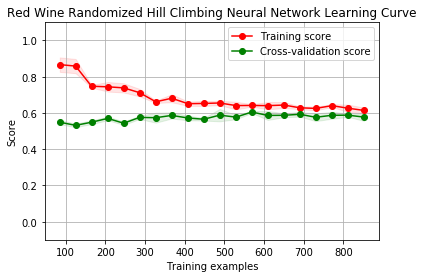

In [9]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model_rhc, X_train_scaled, y_train_hot, n_jobs=-1, random_state=1,
                                                        cv=3, train_sizes=np.linspace(.1, 1.0, 20), verbose=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Red Wine Randomized Hill Climbing Neural Network Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
plt.ylim(-.1,1.1)
plt.legend(loc='upper right')
plt.show()

In [15]:
rhc_acc = []

for i in np.linspace(500,5000,10):
    np.random.seed(123)
    nn_model_rhc = mlrose.NeuralNetworkClassifier(hidden_nodes = [8,8,8], activation = 'softplus', \
                                         algorithm = 'random_hill_climb', max_iters = i, \
                                         bias = True, learning_rate=0.8, \
                                         early_stopping = True, max_attempts = 100)
    nn_model_rhc.fit(X_train_scaled,y_train_hot)
    y_train_pred = nn_model_rhc.predict(X_train_scaled)
    y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
    rhc_acc.append(y_train_accuracy)
    if i%1000==0:
        print(i)

1000.0
2000.0
3000.0
4000.0
5000.0


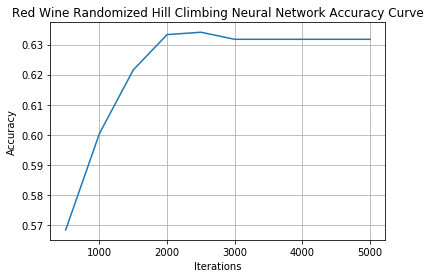

In [16]:
plt.figure()
plt.title("Red Wine Randomized Hill Climbing Neural Network Accuracy Curve")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")

# box-like grid
plt.grid()

plt.plot(np.linspace(500,5000,10), rhc_acc)

# sizes the window for readability and displays the plot
plt.show()

In [17]:
grid_sa={
    'learning_rate':np.linspace(0.04,0.2,5),
    'schedule':[mlrose.GeomDecay(),mlrose.ArithDecay(),mlrose.ExpDecay()]
}

np.random.seed(123)

nn_model_sa = mlrose.NeuralNetworkClassifier(hidden_nodes = [8,8,8], activation = 'softplus', \
                                     algorithm = 'simulated_annealing', max_iters = 5000, \
                                     bias = True, \
                                     early_stopping = True, max_attempts = 100)

clf_sa = GridSearchCV(nn_model_sa, grid_sa, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

clf_sa.fit(X_train_scaled, y_train_hot)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=NeuralNetworkClassifier(activation='softplus',
            algorithm='simulated_annealing', bias=True,
            clip_max=10000000000.0, early_stopping=True,
            hidden_nodes=[8, 8, 8], learning_rate=0.1, max_attempts=100,
            max_iters=5000, mutation_prob=0.1, pop_size=200,
            schedule=<mlrose.decay.GeomDecay object at 0x00000152F833DD68>),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': array([0.04, 0.08, 0.12, 0.16, 0.2 ]), 'schedule': [<mlrose.decay.GeomDecay object at 0x00000152FAF08B00>, <mlrose.decay.ArithDecay object at 0x00000152FAF08978>, <mlrose.decay.ExpDecay object at 0x00000152FAF08D30>]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [18]:
# Extract best hyperparameters from 'grid'
print('Best hyperparameters:\n', clf_sa.best_params_)

# Extract best CV score from 'grid'
print('Best CV accuracy: {:.3f}'.format(clf_sa.best_score_))

# Extract best model from 'grid'
best_model_sa = clf_sa.best_estimator_

# Evaluate test set accuracy
test_acc_sa = best_model_sa.score(X_test_scaled, y_test_hot)

# Print test set accuracy
print('Test set accuracy of best model: {:.3f}'.format(test_acc_sa))

# Mean fit and score time for best parameters
print('Mean fit time: {:.4f}'.format(clf_sa.cv_results_['mean_fit_time'][clf_sa.best_index_]))
print('Mean score time: {:.4f}'.format(clf_sa.cv_results_['mean_score_time'][clf_sa.best_index_]))

Best hyperparameters:
 {'learning_rate': 0.12, 'schedule': <mlrose.decay.GeomDecay object at 0x00000152FAF08B00>}
Best CV accuracy: 0.599
Test set accuracy of best model: 0.541
Mean fit time: 33.8953
Mean score time: 0.0030


[learning_curve] Training set sizes: [ 85 125 165 206 246 286 327 367 408 448 488 529 569 609 650 690 730 771
 811 852]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.5min finished


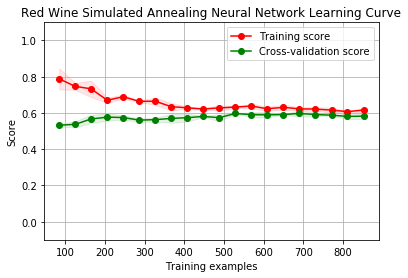

In [19]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model_sa, X_train_scaled, y_train_hot, n_jobs=-1, random_state=1,
                                                        cv=3, train_sizes=np.linspace(.1, 1.0, 20), verbose=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Red Wine Simulated Annealing Neural Network Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
plt.ylim(-.1,1.1)
plt.legend(loc='upper right')
plt.show()

In [20]:
sa_acc = []

for i in np.linspace(625,5000,8):
    np.random.seed(123)
    nn_model_sa = mlrose.NeuralNetworkClassifier(hidden_nodes = [8,8,8], activation = 'softplus', \
                                         algorithm = 'simulated_annealing', max_iters = i, \
                                         bias = True, learning_rate=0.12, schedule = mlrose.GeomDecay(), \
                                         early_stopping = True, max_attempts = 100)
    nn_model_sa.fit(X_train_scaled,y_train_hot)
    y_train_pred = nn_model_sa.predict(X_train_scaled)
    y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
    sa_acc.append(y_train_accuracy)
    if i%1000==0:
        print(i)


5000.0


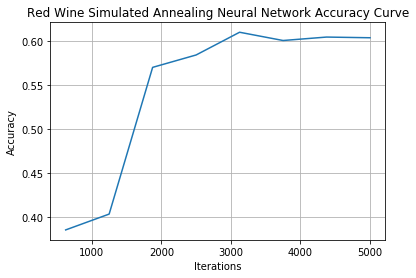

In [21]:
plt.figure()
plt.title("Red Wine Simulated Annealing Neural Network Accuracy Curve")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")

# box-like grid
plt.grid()

plt.plot(np.linspace(625,5000,8), sa_acc)

plt.show()

In [22]:
grid_ga={
    'pop_size':np.linspace(100,400,4),
    'mutation_prob':np.linspace(0.05,0.3,6)
}

np.random.seed(123)

nn_model_ga = mlrose.NeuralNetworkClassifier(hidden_nodes = [8,8,8], activation = 'softplus', \
                                     algorithm = 'genetic_alg', max_iters = 5000, clip_max = 1.1, \
                                     bias = True, early_stopping = True, max_attempts = 100)

clf_ga = GridSearchCV(nn_model_ga, grid_ga, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

clf_ga.fit(X_train_scaled, y_train_hot)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 25.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=NeuralNetworkClassifier(activation='softplus', algorithm='genetic_alg',
            bias=True, clip_max=1.1, early_stopping=True,
            hidden_nodes=[8, 8, 8], learning_rate=0.1, max_attempts=100,
            max_iters=5000, mutation_prob=0.1, pop_size=200,
            schedule=<mlrose.decay.GeomDecay object at 0x00000152F833DD68>),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'pop_size': array([100., 200., 300., 400.]), 'mutation_prob': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [23]:
# Extract best hyperparameters from 'grid'
print('Best hyperparameters:\n', clf_ga.best_params_)

# Extract best CV score from 'grid'
print('Best CV accuracy: {:.3f}'.format(clf_ga.best_score_))

# Extract best model from 'grid'
best_model_ga = clf_ga.best_estimator_

# Evaluate test set accuracy
test_acc_ga = best_model_ga.score(X_test_scaled, y_test_hot)

# Print test set accuracy
print('Test set accuracy of best model: {:.3f}'.format(test_acc_ga))

# Mean fit and score time for best parameters
print('Mean fit time: {:.4f}'.format(clf_ga.cv_results_['mean_fit_time'][clf_ga.best_index_]))
print('Mean score time: {:.4f}'.format(clf_ga.cv_results_['mean_score_time'][clf_ga.best_index_]))

Best hyperparameters:
 {'mutation_prob': 0.1, 'pop_size': 400.0}
Best CV accuracy: 0.480
Test set accuracy of best model: 0.384
Mean fit time: 120.9398
Mean score time: 0.0013


[learning_curve] Training set sizes: [ 85 125 165 206 246 286 327 367 408 448 488 529 569 609 650 690 730 771
 811 852]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 18.2min finished


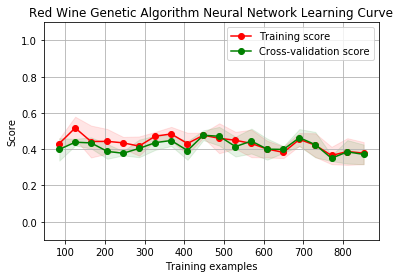

In [24]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model_ga, X_train_scaled, y_train_hot, n_jobs=-1, random_state=1,
                                                        cv=3, train_sizes=np.linspace(.1, 1.0, 20), verbose=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Red Wine Genetic Algorithm Neural Network Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
plt.ylim(-.1,1.1)
plt.legend(loc='upper right')
plt.show()

In [ ]:
ga_acc = []

for i in np.linspace(625,5000,8):
    np.random.seed(123)
    nn_model_ga = mlrose.NeuralNetworkClassifier(hidden_nodes = [8,8,8], activation = 'softplus', \
                                         algorithm = 'genetic_alg', max_iters = i, clip_max=1.1, \
                                         bias = True, mutation_prob=0.1, \
                                         pop_size = 400, early_stopping = True, max_attempts = 100)
    nn_model_ga.fit(X_train_scaled,y_train_hot)
    y_train_pred = nn_model_ga.predict(X_train_scaled)
    y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
    ga_acc.append(y_train_accuracy)
    print(i)

625.0
1250.0
1875.0
2500.0
3125.0


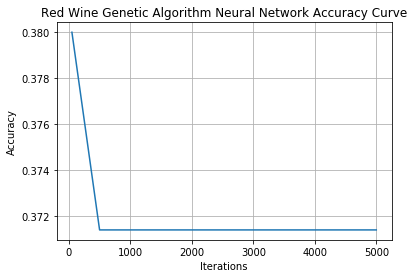

In [29]:
plt.figure()
plt.title("Red Wine Genetic Algorithm Neural Network Accuracy Curve")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")

# box-like grid
plt.grid()

plt.plot([50,500,5000], ga_acc)

plt.show()

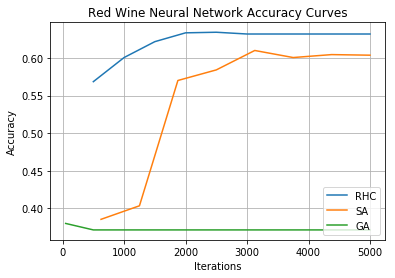

In [30]:
plt.figure()
plt.title("Red Wine Neural Network Accuracy Curves")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")

# box-like grid
plt.grid()
plt.plot(np.linspace(500,5000,10), rhc_acc, label='RHC')
plt.plot(np.linspace(625,5000,8), sa_acc, label='SA')
plt.plot([50,500,5000], ga_acc, label='GA')
plt.legend(loc='lower right')
plt.show()